# Subpopulation Prediction

This notebook explores both descriptive analysis and predictive analysis of relationship estimations across subpopulations of age. The goal is to illustrate how predictions and communication patterns vary widely across different populations.

In [52]:
%matplotlib inline
import pickle
from collections import Counter
import csv
import os, sys, inspect

from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score, KFold
import shap

# Stat imports
from scipy.stats import pointbiserialr

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
import rpy2
from rpy2.robjects.packages import importr
utils = importr('utils')
lmtest = importr('lmtest')
Hmisc = importr("Hmisc")
pandas2ri.activate()

# Visualization imports
import statsmodels.api as sm
import seaborn as sns
import shap
shap.initjs()
lowess = sm.nonparametric.lowess

# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()

from model_util import *
from stats_util import *
from GroupKFoldSample import GroupKFold as GroupKFoldSample

In [120]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

In [53]:
predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness'
]

replace_dict_4clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 1,
        "family_live_together": 3,
        "sig_other": 3
    }
}

dict_4clf_labels = {
        "work": "work",
        "friend": "social_separate",
        "task": "task",
        "family_live_separate": "social_separate",
        "family_live_together": "family_together",
        "sig_other": "family_together"
}

replace_dict_6clf = {
    'contact_type': {
        "work": 0,
        "friend": 1,
        "task": 2,
        "family_live_separate": 3,
        "family_live_together": 4,
        "sig_other": 5
    }
}


contact_types_6clf = list(replace_dict_6clf['contact_type'].keys())
contact_types_4clf = ["work", "social_separate", "task", "family_together"]

age_qlabels = ["age_q" + str(x) for x in range(1,5)]

## Load data

In [54]:
top5_all_sb_train_data = pickle.load(open('../data/final_sandbox/top5_all_train_features.df', 'rb'))
top5_all_sb_test_data = pickle.load(open('../data/final_sandbox/top5_all_test_features.df', 'rb'))

top5_all_data = pd.concat([top5_all_sb_train_data, top5_all_sb_test_data], axis=0)
top5_all_data['ego_age_q'], bins = pd.qcut(top5_all_data['ego_age'], q=4, labels=age_qlabels, retbins=True)

top5_unique = top5_all_data.drop_duplicates(subset='pid')
q_age_dict = pd.Series(top5_unique['ego_age_q'].values, index=top5_unique['pid']).to_dict()

In [4]:
top5_base_sb_train_data = pickle.load(open('../data/final_sandbox/top5_baseline_train_features.df', 'rb'))
top5_base_sb_test_data = pickle.load(open('../data/final_sandbox/top5_baseline_test_features.df', 'rb'))

#top5_base_sb_train_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_train_features.df', 'rb'))
#top5_base_sb_test_data = pickle.load(open('../data/final_features/all_contacts_age_gender_dedup_nan_test_features.df', 'rb'))

top5_base_data = pd.concat([top5_base_sb_train_data, top5_base_sb_test_data], axis=0)
top5_base_data['ego_age_q'] = top5_base_data['pid'].map(q_age_dict)

# collapse classes
top5_all_data['contact_type'] = top5_all_data['contact_type'].map(dict_4clf_labels)

### Sandbox: Final experiment feature creation

In [29]:
top5_all_sb_test_data['ego_age'].describe()

count    210.000000
mean      37.690476
std       12.053485
min       18.000000
25%       28.000000
50%       36.000000
75%       48.000000
max       66.000000
Name: ego_age, dtype: float64

In [30]:
top5_all_sb_train_data['ego_age'].describe()

count    735.000000
mean      38.564626
std        9.642145
min       21.000000
25%       31.000000
50%       38.000000
75%       46.000000
max       66.000000
Name: ego_age, dtype: float64

In [13]:
print(top5_all_sb_train_data.columns.shape)
comm_cols = ~(top5_all_sb_train_data.columns.str.contains("ego") |
              top5_all_sb_train_data.columns.str.contains("loc") |
              top5_all_sb_train_data.columns.str.contains("visit_reason"))

(343,)


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
# communication features + age
top5_train_age_comm_data = top5_all_sb_train_data.loc[:, comm_cols]
top5_train_age_comm_data['ego_age'] = top5_all_sb_train_data['ego_age']

top5_test_age_comm_data = top5_all_sb_test_data.loc[:, comm_cols]
top5_test_age_comm_data['ego_age'] = top5_all_sb_test_data['ego_age']

pickle.dump(top5_train_age_comm_data, open("../data/final_sandbox/top5_age_comm_train_features.df", "wb"), -1)
pickle.dump(top5_test_age_comm_data, open("../data/final_sandbox/top5_age_comm_test_features.df", "wb"), -1)

In [23]:
# age features only
top5_train_age_only_data = top5_all_sb_train_data[['pid','combined_hash', 'contact_type', 'ego_age']]
top5_test_age_only_data = top5_all_sb_test_data[['pid','combined_hash', 'contact_type', 'ego_age']]

In [25]:
pickle.dump(top5_train_age_only_data, open("../data/final_sandbox/top5_age_only_train_features.df", "wb"), -1)
pickle.dump(top5_test_age_only_data, open("../data/final_sandbox/top5_age_only_test_features.df", "wb"), -1)

## Build datasets

In [32]:
# build baseline data
# for q in range(1,5):
#     top5_base_q_train = top5_base_data.loc[top5_base_data['ego_age_q'] == "age_q{}".format(q)]
#     top5_base_q_test = top5_base_data.loc[top5_base_data['ego_age_q'] != "age_q{}".format(q)]
#     print(top5_base_q_train.shape)
#     print(top5_base_q_test.shape)
#     pickle.dump(top5_base_q_train, open("../data/subpop_features/top5_base_q{}_train_features.df".format(q), "wb"), -1)
#     pickle.dump(top5_base_q_test, open("../data/subpop_features/top5_base_q{}_test_features.df".format(q), "wb"), -1)

(260, 192)
(685, 192)
(215, 192)
(730, 192)
(255, 192)
(690, 192)
(215, 192)
(730, 192)


In [33]:
# build all features data
# for q in range(1,5):
#     top5_all_q_train = top5_all_data.loc[top5_all_data['ego_age_q'] == "age_q{}".format(q)]
#     top5_all_q_test = top5_all_data.loc[top5_all_data['ego_age_q'] != "age_q{}".format(q)]
#     print(top5_all_q_train.shape)
#     print(top5_all_q_test.shape)
#     pickle.dump(top5_all_q_train, open("../data/subpop_features/top5_all_q{}_train_features.df".format(q), "wb"), -1)
#     pickle.dump(top5_all_q_test, open("../data/subpop_features/top5_all_q{}_test_features.df".format(q), "wb"), -1)

(260, 344)
(685, 344)
(215, 344)
(730, 344)
(255, 344)
(690, 344)
(215, 344)
(730, 344)


In [7]:
# prep datasets for random forest predictions
#top5_all_data = top5_all_data.replace(replace_dict_4clf)
#top5_base_data = top5_base_data.replace(replace_dict_4clf)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

## Descriptive Statistics

In [55]:
def build_contact_corr(in_df):
    """Returns contact type correlation information for the given dataframe.
    
    Args:
        in_df (pandas.DataFrame): df of features
    
    Returns:
        corrs (numpy.array)
        p_vals (numpy.array)
        cols (list)

    """
    df_one_hot = pd.concat([in_df, pd.get_dummies(in_df['contact_type'])], axis=1)
    corr_df = df_one_hot.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
    corrs, counts, p_vals = run_r_corr(corr_df, corr_type='pearson')

    cols = corr_df.columns.values

    return corrs, p_vals, cols

def get_sig_features(cols, target, corrs, p_vals, exclude_cols=[], alpha=0.05):
    """Returns dataframe of features significantly correlated with the target variable.
    
    Args:
        cols (list): list of column names
        target (str): target feature to extract correlations from
        corrs (numpy.array): correlation matrix
        p_vals (numpy.array): p value matrix
        exclude_cols (list): features to exclude
        alpha (float): significance threshold
        
    Returns:
        pandas.DataFrame: df of significant features
        
    """
    idx = np.where(cols == target)
    sel_corrs = corrs[idx]
    sel_p_vals = p_vals[idx]
    sel_stats = np.transpose(np.vstack((sel_corrs, sel_p_vals)))
    sel_df = pd.DataFrame(sel_stats, index=cols, columns=['corr', 'p'])
    sig_features = sel_df.loc[sel_df['p'] < alpha]
    sig_features = sig_features[~sig_features.index.isin(exclude_cols)]
    sig_features = sig_features.sort_values(by='p')
    return sig_features

exclude_cols = ['social_separate', 'family_together', 'work', 'task', 'q1_want', 'q2_talk', 'q3_loan', 'q4_closeness']

### Population analysis

In [121]:
top5_all_data.columns.values

array(['pid', 'combined_hash', 'total_comms', 'total_comm_days',
       'contact_type', 'total_calls', 'total_sms', 'total_sms_days',
       'total_call_days', 'reg_call', 'reg_sms', 'reg_comm',
       'time_of_day_0_call', 'time_of_day_1_call', 'time_of_day_2_call',
       'time_of_day_3_call', 'time_of_day_4_call', 'time_of_day_5_call',
       'day_0_call', 'day_1_call', 'day_2_call', 'day_3_call',
       'day_4_call', 'day_5_call', 'day_6_call', 'time_of_day_0_sms',
       'time_of_day_1_sms', 'time_of_day_2_sms', 'time_of_day_3_sms',
       'time_of_day_4_sms', 'time_of_day_5_sms', 'day_0_sms', 'day_1_sms',
       'day_2_sms', 'day_3_sms', 'day_4_sms', 'day_5_sms', 'day_6_sms',
       'time_of_day_0_call_dur', 'time_of_day_1_call_dur',
       'time_of_day_2_call_dur', 'time_of_day_3_call_dur',
       'time_of_day_4_call_dur', 'time_of_day_5_call_dur',
       'day_0_call_dur', 'day_1_call_dur', 'day_2_call_dur',
       'day_3_call_dur', 'day_4_call_dur', 'day_5_call_dur',
       'da

#### Errand/Shop semantic location

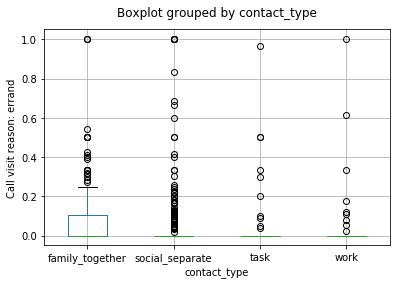

In [131]:
top5_all_data.boxplot(column='all_call_visit_reason:errand', by='contact_type')
plt.ylabel("Call visit reason: errand")
#plt.ylim(0,15)
plt.title("")
plt.show()

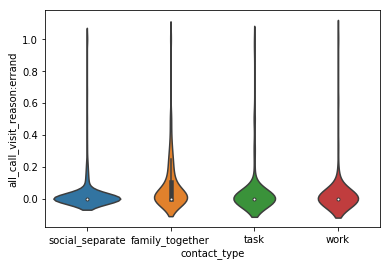

In [130]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:errand", data=top5_all_data, split=True)
plt.show()

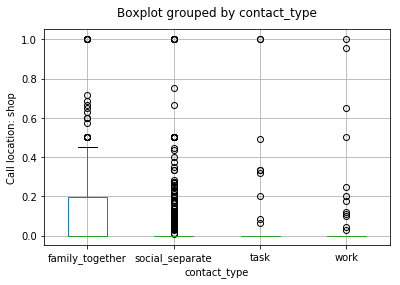

In [134]:
top5_all_data.boxplot(column='all_call_loc:shop', by='contact_type')
plt.ylabel("Call location: shop")
#plt.ylim(0,15)
plt.title("")
plt.show()

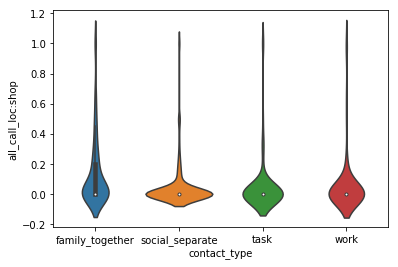

In [137]:
sns.violinplot(x="contact_type", y="all_call_loc:shop", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### Home semantic location

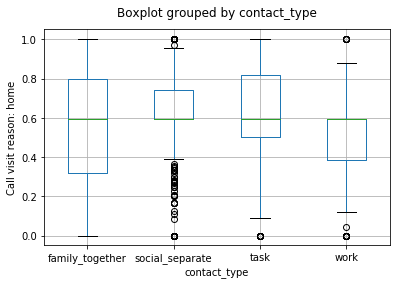

In [135]:
top5_all_data.boxplot(column='all_call_visit_reason:home', by='contact_type')
plt.ylabel("Call visit reason: home")
#plt.ylim(0,15)
plt.title("")
plt.show()

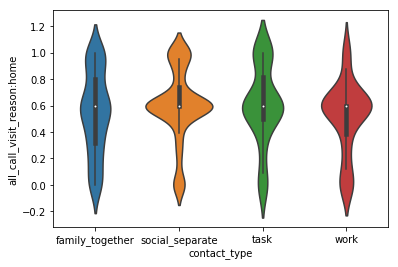

In [139]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:home", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### Work semantic location

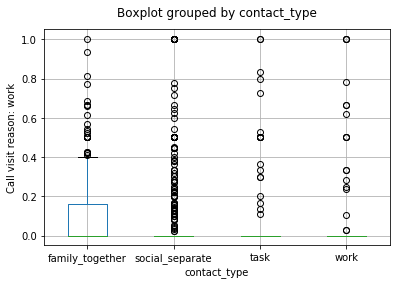

In [143]:
top5_all_data.boxplot(column='all_call_visit_reason:work', by='contact_type')
plt.ylabel("Call visit reason: work")
#plt.ylim(0,0.5)
plt.title("")
plt.show()

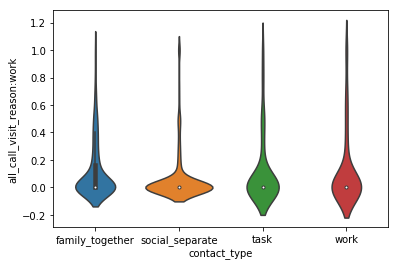

In [141]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:work", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

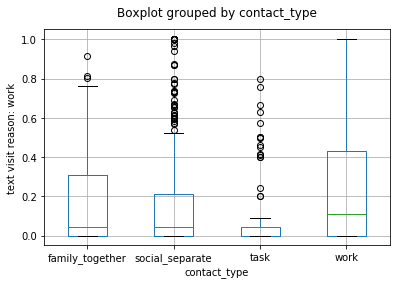

In [145]:
top5_all_data.boxplot(column='all_sms_visit_reason:work', by='contact_type')
plt.ylabel("text visit reason: work")
#plt.ylim(0,0.5)
plt.title("")
plt.show()

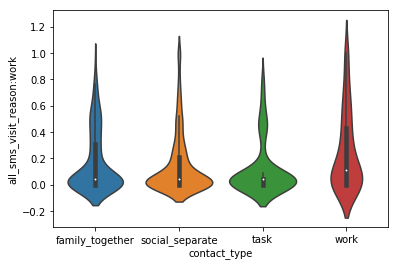

In [146]:
sns.violinplot(x="contact_type", y="all_sms_visit_reason:work", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### Socialize semantic location

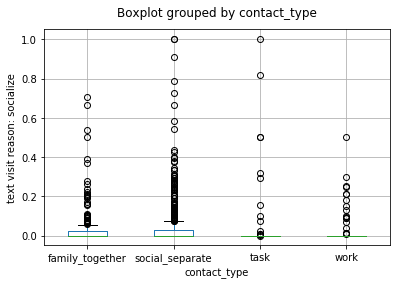

In [147]:
top5_all_data.boxplot(column='all_sms_visit_reason:socialize', by='contact_type')
plt.ylabel("text visit reason: socialize")
#plt.ylim(0,0.5)
plt.title("")
plt.show()

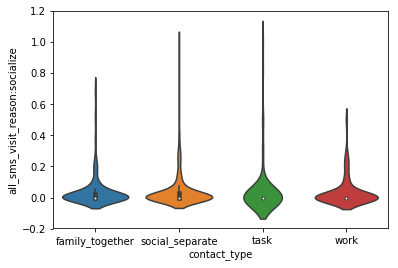

In [149]:
sns.violinplot(x="contact_type", y="all_sms_visit_reason:socialize", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

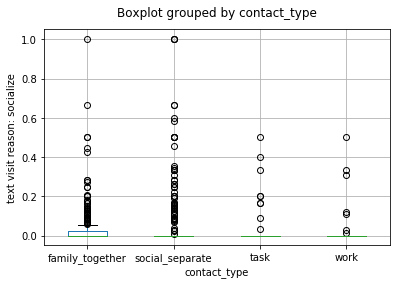

In [150]:
top5_all_data.boxplot(column='all_call_visit_reason:socialize', by='contact_type')
plt.ylabel("text visit reason: socialize")
#plt.ylim(0,0.5)
plt.title("")
plt.show()

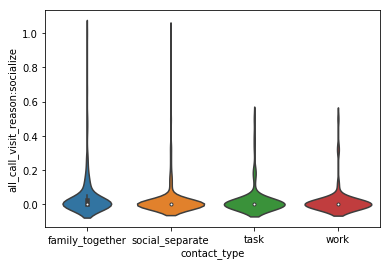

In [151]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:socialize", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### travel semantic location

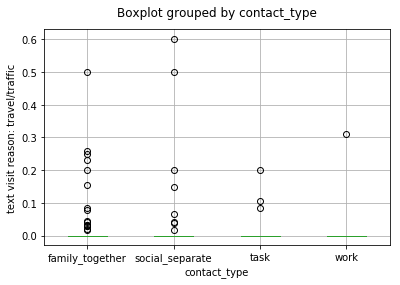

In [152]:
top5_all_data.boxplot(column='all_call_visit_reason:travel/traffic', by='contact_type')
plt.ylabel("text visit reason: travel/traffic")
#plt.ylim(0,0.5)
plt.title("")
plt.show()

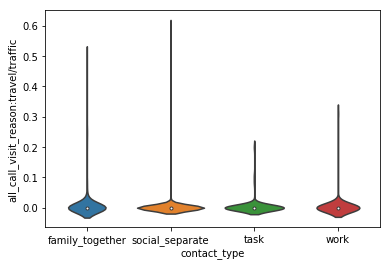

In [153]:
sns.violinplot(x="contact_type", y="all_call_visit_reason:travel/traffic", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

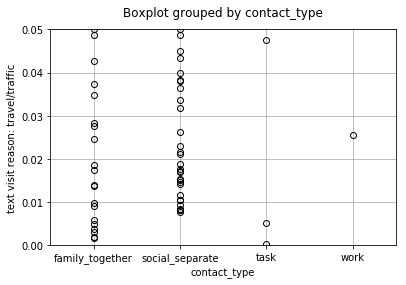

In [157]:
top5_all_data.boxplot(column='all_sms_visit_reason:travel/traffic', by='contact_type')
plt.ylabel("text visit reason: travel/traffic")
plt.ylim(0,0.05)
plt.title("")
plt.show()

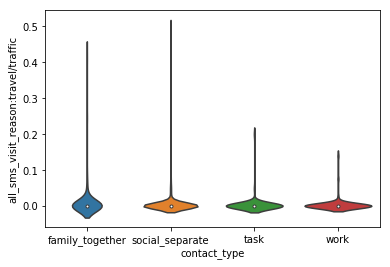

In [155]:
sns.violinplot(x="contact_type", y="all_sms_visit_reason:travel/traffic", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### Spiritual semantic location

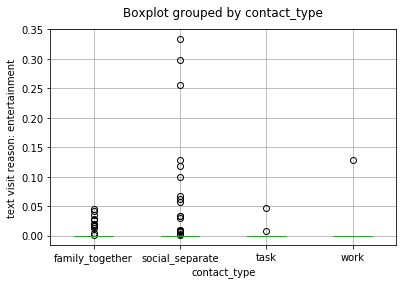

In [165]:
top5_all_data.boxplot(column='all_sms_loc:spiritual', by='contact_type')
plt.ylabel("text location: spiritual")
#plt.ylim(0,0.05)
plt.title("")
plt.show()

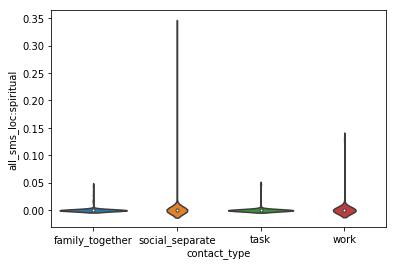

In [166]:
sns.violinplot(x="contact_type", y="all_sms_loc:spiritual", data=top5_all_data, split=True, order=['family_together', 'social_separate', 'task', 'work'])
plt.show()

#### Age correlations with communication

In [56]:
corr_df = top5_all_data.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [67]:
exclude_cols = corr_df.columns[corr_df.columns.str.startswith('ego') 
                               | corr_df.columns.str.contains('loc') 
                               | corr_df.columns.str.contains('visit_reason')]                     

In [69]:
cols = corr_df.columns.values
age_idx = np.where(cols=='ego_age')
sig_age_df = get_sig_features(cols, 'ego_age', r_corrs, r_p_vals, exclude_cols=exclude_cols)
pd.reset_option('display.float_format')# = '{:,.2f}%'.format
sig_age_df.style.clear()
sig_age_df

,corr,p
call_tendency,0.181033,2.596729e-07
time_of_day_0_comm,-0.145688,6.480452e-05
time_of_day_0_sms,-0.144720,7.398989e-05
time_of_day_5_sms,-0.141237,1.186053e-04
time_of_day_0_sms_nan_indicator,0.139195,1.554064e-04
reg_sms,-0.138867,1.622991e-04
in_out_sms_nan_indicator,0.136113,2.323195e-04
std_out_sms_nan_indicator,0.132329,3.747838e-04
day_6_sms,-0.131879,3.963414e-04
total_sms_days,-0.131164,4.338003e-04


### All quartile analysis

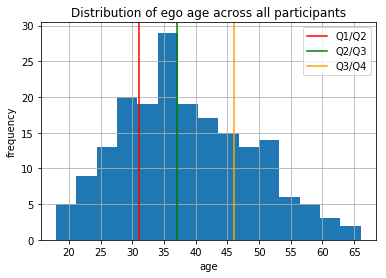

In [33]:
top5_all_data.drop_duplicates(subset='pid')['ego_age'].hist(bins=15)
plt.ylabel("frequency")
plt.xlabel("age")
plt.xticks(np.arange(20, 66, 5))
plt.axvline(x=31, color="red", label="Q1/Q2")
plt.axvline(x=37, color="green", label="Q2/Q3")
plt.axvline(x=46, color="orange", label="Q3/Q4")
#plt.axvline(x=66, color="red", label="Q4")
plt.legend()
plt.title("Distribution of ego age across all participants")
plt.savefig("figures/q_age_hist.png", dpi=300)

In [31]:
quartiles = top5_all_data['ego_age'].quantile([0.25, 0.5, 0.75, 1])
terciles = top5_all_data['ego_age'].quantile([0.33, 0.67, 1])

print(quartiles)
print(terciles)

0.25    31.0
0.50    37.0
0.75    46.0
1.00    66.0
Name: ego_age, dtype: float64
0.33    33.0
0.67    43.0
1.00    66.0
Name: ego_age, dtype: float64


In [32]:
print(top5_all_data['ego_age_q'].value_counts())
print(bins)

age_q1    260
age_q3    255
age_q4    215
age_q2    215
Name: ego_age_q, dtype: int64
[18. 31. 37. 46. 66.]


In [33]:
print((top5_all_data['ego_age'] <= 31).sum())
print(((top5_all_data['ego_age'] <= 37) & (top5_all_data['ego_age'] > 31)).sum())
print(((top5_all_data['ego_age'] <= 46) & (top5_all_data['ego_age'] > 37)).sum())
print(((top5_all_data['ego_age'] <= 66) & (top5_all_data['ego_age'] > 46)).sum())

260
215
255
215


In [34]:
top5_all_data_one_hot = pd.concat([top5_all_data, pd.get_dummies(top5_all_data['ego_age_q'])], axis=1)

In [35]:
corr_df = top5_all_data_one_hot.drop(labels=['pid','combined_hash', 'contact_type', 'ego_age_q'], axis='columns')
r_corrs, r_counts, r_p_vals = run_r_corr(corr_df, corr_type='pearson')


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [36]:
cols = corr_df.columns.values
age_q1_idx = np.where(cols=='age_q1')
age_q2_idx = np.where(cols=='age_q2')
age_q3_idx = np.where(cols=='age_q3')
age_q4_idx = np.where(cols=='age_q4')

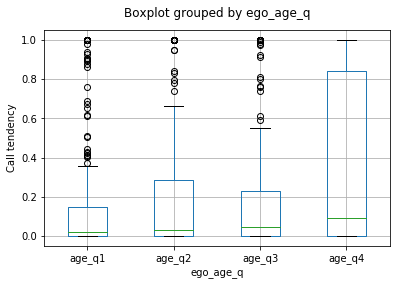

In [116]:
top5_all_data.boxplot(column='call_tendency', by='ego_age_q')
plt.ylabel("Call tendency")
plt.title("")
plt.show()

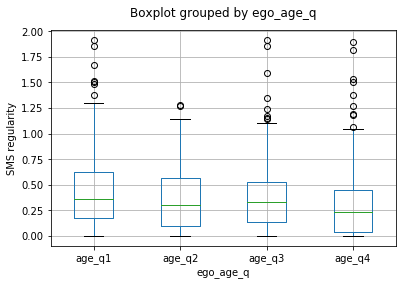

In [115]:
top5_all_data.boxplot(column='reg_sms', by='ego_age_q')
plt.ylabel("SMS regularity")
plt.title("")
plt.show()

### Q1

contact_type
family_together    20.384615
social_separate    67.307692
task                5.000000
work                7.307692
Name: total_comms, dtype: float64

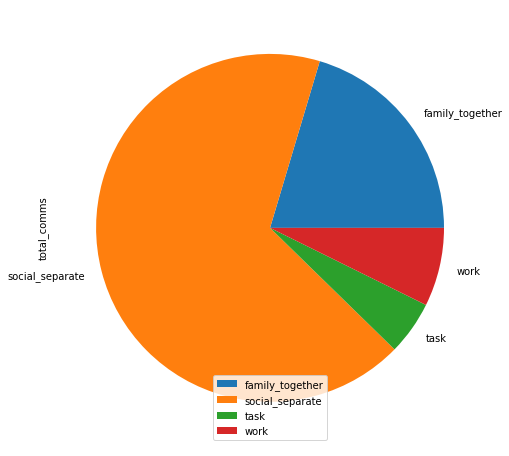

In [34]:
q1_df = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q1']
q1_types = q1_df.drop_duplicates('combined_hash')
q1_groups = q1_types.groupby('contact_type').count()
q1_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower center')
q1_pct = q1_groups['total_comms'] / q1_groups['total_comms'].sum() * 100
display(q1_pct)

In [41]:
age_q1_corrs = r_corrs[age_q1_idx]
age_q1_p_vals = r_p_vals[age_q1_idx]

age_q1_stats = np.transpose(np.vstack((age_q1_corrs, age_q1_p_vals)))
age_q1_df = pd.DataFrame(age_q1_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q1_df.loc[age_q1_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.loc[~sig_features.index.str.startswith('ego')]
sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features.head())
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_6clf)])
#display(age_q1_df.loc[age_q1_df.index.isin(contact_types_4clf)])

,corr,p
time_of_day_5_sms,0.1286,0.0006
time_of_day_0_comm,0.1247,0.0010
all_sms_visit_reason:travel/traffic,0.1245,0.0010
time_of_day_0_sms,0.1202,0.0016
time_of_day_5_comm,0.1189,0.0019


#### Q1 contact type correlations

In [78]:
q1_r_corrs, q1_r_p_vals, q1_cols = build_contact_corr(q1_df)

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [84]:
q1_ss_sig_df = get_sig_features(q1_cols, 'social_separate', q1_r_corrs, q1_r_p_vals, exclude_cols)
q1_ss_sig_df[:10]

,corr,p
reg_call,-0.2766,0.0001
total_call_days,-0.2544,0.0005
time_of_day_5_long_call_out,-0.2531,0.0005
max_in_call,-0.2492,0.0007
mean_in_call,-0.2491,0.0007
reg_comm,-0.2414,0.0011
std_out_sms_nan_indicator,-0.2323,0.0019
std_out_call,-0.2301,0.0022
total_comm_days,-0.2241,0.0031
total_calls,-0.2233,0.0033


In [85]:
q1_ft_sig_df = get_sig_features(q1_cols, 'family_together', q1_r_corrs, q1_r_p_vals, exclude_cols)
q1_ft_sig_df[:10]

,corr,p
total_call_days,0.4250,0.0000
reg_call,0.4207,0.0000
reg_comm,0.3868,0.0000
total_comm_days,0.3840,0.0000
all_call_loc:home_nan_indicator,-0.3367,0.0000
all_call_visit_reason:entertainment_nan_indicator,-0.3332,0.0000
time_of_day_5_long_call_out,0.3266,0.0000
total_calls,0.3163,0.0000
std_out_sms_nan_indicator,0.3087,0.0000
mean_in_call,0.3084,0.0000


In [86]:
q1_w_sig_df = get_sig_features(q1_cols, 'work', q1_r_corrs, q1_r_p_vals, exclude_cols)
q1_w_sig_df[:10]

,corr,p
day_0_comm,0.2730,0.0001
day_0_miss_call_out,0.2571,0.0004
time_of_day_1_miss_call_out,0.2475,0.0007
time_of_day_3_miss_call_out,0.2315,0.0020
time_of_day_2_miss_call_out,0.2297,0.0023
day_0_sms,0.2288,0.0024
out_call_loc:outdoors/recreation,0.2207,0.0038
all_call_loc:outdoors/recreation,0.2109,0.0065
time_of_day_2_comm,0.2076,0.0078
out_sms_loc:spiritual,0.2061,0.0085


In [87]:
q1_t_sig_df = get_sig_features(q1_cols, 'task', q1_r_corrs, q1_r_p_vals, exclude_cols)
q1_t_sig_df[:10]

,corr,p
all_call_loc:spiritual,0.2640,0.0002
dur_call_loc:spiritual,0.2573,0.0004
out_call_loc:spiritual,0.2568,0.0004
out_call_visit_reason:exercise,0.2377,0.0014
out_sms_loc:outdoors/recreation,0.2318,0.0020
all_call_visit_reason:exercise,0.2221,0.0035
all_sms_loc:outdoors/recreation,0.2112,0.0064
all_sms_visit_reason:socialize,0.2098,0.0069
all_sms_loc:nightlife,0.1893,0.0195


### Q2

contact_type
family_together    25.581395
social_separate    56.744186
task               10.697674
work                6.976744
Name: total_comms, dtype: float64

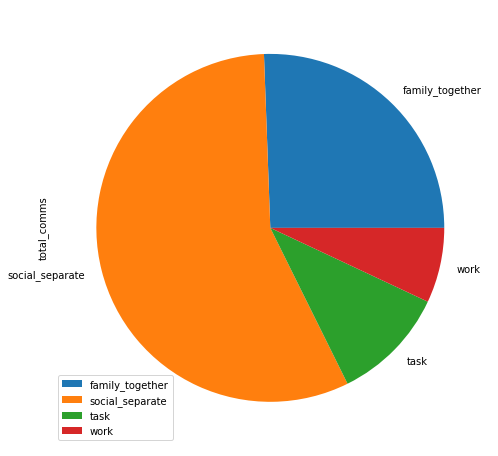

In [36]:
q2_df = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q2']
q2_types = q2_df.drop_duplicates('combined_hash')
q2_groups = q2_types.groupby('contact_type').count()
q2_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')
q2_pct = q2_groups['total_comms'] / q2_groups['total_comms'].sum() * 100
display(q2_pct)

In [89]:
age_q2_corrs = r_corrs[age_q2_idx]
age_q2_p_vals = r_p_vals[age_q2_idx]

age_q2_stats = np.transpose(np.vstack((age_q2_corrs, age_q2_p_vals)))
age_q2_df = pd.DataFrame(age_q2_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q2_df.loc[age_q2_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.loc[~sig_features.index.str.startswith('ego')]
sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_6clf)])
#display(age_q2_df.loc[age_q2_df.index.isin(contact_types_4clf)])

,corr,p
out_sms_loc:professional/medical_office,0.2402,0.0000
all_sms_loc:professional/medical_office,0.2112,0.0000
all_sms_loc:food,-0.1029,0.0098
all_call_loc:professional/medical_office,0.0943,0.0215
all_sms_loc:anothers_home,-0.0930,0.0241
out_sms_visit_reason:home,0.0891,0.0333


#### Q2 contact type correlations

In [90]:
q2_r_corrs, q2_r_p_vals, q2_cols = build_contact_corr(q2_df)

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [91]:
q2_ss_sig_df = get_sig_features(q2_cols, 'social_separate', q2_r_corrs, q2_r_p_vals, exclude_cols)
q2_ss_sig_df[:10]

,corr,p
std_out_sms_nan_indicator,-0.3163,0.0000
std_in_sms_nan_indicator,-0.3163,0.0000
time_of_day_0_sms_nan_indicator,-0.3037,0.0001
call_tendency,-0.3003,0.0001
all_sms_visit_reason:entertainment_nan_indicator,-0.2830,0.0004
all_sms_loc:home_nan_indicator,-0.2830,0.0004
sms_last_6_wks,0.2585,0.0016
in_out_sms_nan_indicator,-0.2371,0.0051
max_out_call,-0.2320,0.0066
day_2_comm,-0.2317,0.0067


In [92]:
q2_ft_sig_df = get_sig_features(q2_cols, 'family_together', q2_r_corrs, q2_r_p_vals, exclude_cols)
q2_ft_sig_df[:10]

,corr,p
reg_call,0.3528,0.0000
reg_comm,0.3370,0.0000
total_comm_days,0.3350,0.0000
total_call_days,0.3323,0.0000
max_in_call,0.3306,0.0000
mean_in_call,0.3297,0.0000
total_calls,0.3246,0.0000
tot_long_calls,0.3236,0.0000
mean_out_call,0.3139,0.0000
med_in_call,0.2988,0.0001


In [93]:
q2_w_sig_df = get_sig_features(q2_cols, 'work', q2_r_corrs, q2_r_p_vals, exclude_cols)
q2_w_sig_df[:10]

,corr,p
time_of_day_1_call,0.2697,0.0009
out_call_loc:nightlife,0.2496,0.0027
day_2_sms,0.2268,0.0085
out_call_visit_reason:travel/traffic,0.2166,0.0136
all_call_loc:travel/transport,0.2164,0.0137
day_2_comm,0.1882,0.0441
all_call_visit_reason:travel/traffic,0.1863,0.0476


In [94]:
q2_t_sig_df = get_sig_features(q2_cols, 'task', q2_r_corrs, q2_r_p_vals, exclude_cols)
q2_t_sig_df[:10]

,corr,p
ego_education_pro_doctoral,0.4458,0.0000
all_sms_loc:home_nan_indicator,0.3292,0.0000
all_sms_visit_reason:entertainment_nan_indicator,0.3292,0.0000
time_of_day_0_sms_nan_indicator,0.3132,0.0001
comm_last_2_wks,0.3104,0.0001
in_out_sms_nan_indicator,0.2881,0.0003
ego_race_asian,0.2808,0.0004
out_call_visit_reason:work,0.2689,0.0009
std_in_sms_nan_indicator,0.2624,0.0013
std_out_sms_nan_indicator,0.2624,0.0013


### Q3

contact_type
family_together    24.705882
social_separate    58.431373
task                8.627451
work                8.235294
Name: total_comms, dtype: float64

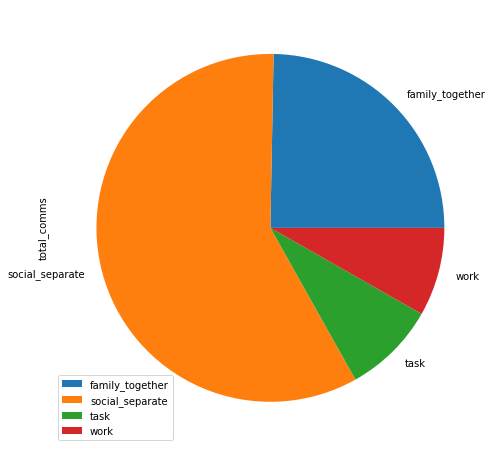

In [37]:
q3_df = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q3']
q3_types = q3_df.drop_duplicates('combined_hash')
q3_groups = q3_types.groupby('contact_type').count()
q3_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')
q3_pct = q3_groups['total_comms'] / q3_groups['total_comms'].sum() * 100
display(q3_pct)

In [97]:
age_q3_corrs = r_corrs[age_q3_idx]
age_q3_p_vals = r_p_vals[age_q3_idx]

age_q3_stats = np.transpose(np.vstack((age_q3_corrs, age_q3_p_vals)))
age_q3_df = pd.DataFrame(age_q3_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q3_df.loc[age_q3_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.loc[~sig_features.index.str.startswith('ego')]
sig_features = sig_features.sort_values(by='p')

pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_6clf)])
#display(age_q3_df.loc[age_q3_df.index.isin(contact_types_4clf)])

,corr,p
out_call_visit_reason:errand,0.0942,0.0217
all_call_visit_reason:errand,0.0871,0.0390
out_sms_visit_reason:other,-0.0867,0.0401


#### q3 contact type correlations

In [98]:
q3_r_corrs, q3_r_p_vals, q3_cols = build_contact_corr(q3_df)

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [99]:
q3_ss_sig_df = get_sig_features(q3_cols, 'social_separate', q3_r_corrs, q3_r_p_vals, exclude_cols)
q3_ss_sig_df[:10]

,corr,p
time_of_day_5_sms,0.1944,0.0212
mean_out_call,-0.1818,0.0372
std_in_sms,0.1800,0.0403
call_tendency,-0.1797,0.0409


In [100]:
q3_ft_sig_df = get_sig_features(q3_cols, 'family_together', q3_r_corrs, q3_r_p_vals, exclude_cols)
q3_ft_sig_df[:10]

,corr,p
reg_comm,0.3181,0.0000
reg_call,0.3086,0.0000
mean_out_call,0.3004,0.0000
total_comm_days,0.2919,0.0000
total_call_days,0.2726,0.0002
total_calls,0.2650,0.0004
max_out_call,0.2467,0.0012
all_call_loc:home_nan_indicator,-0.2396,0.0019
reg_sms,0.2386,0.0020
all_call_visit_reason:entertainment_nan_indicator,-0.2355,0.0024


In [101]:
q3_w_sig_df = get_sig_features(q3_cols, 'work', q3_r_corrs, q3_r_p_vals, exclude_cols)
q3_w_sig_df[:10]

,corr,p
out_call_loc:spiritual,0.2042,0.0132
all_call_loc:spiritual,0.2010,0.0155


In [102]:
q3_t_sig_df = get_sig_features(q3_cols, 'task', q3_r_corrs, q3_r_p_vals, exclude_cols)
q3_t_sig_df[:10]

,corr,p
in_out_sms_nan_indicator,0.3093,0.0000
time_of_day_0_sms_nan_indicator,0.2657,0.0003
all_sms_loc:home_nan_indicator,0.2495,0.0010
all_sms_visit_reason:entertainment_nan_indicator,0.2495,0.0010
time_of_day_0_comm_out_nan_indicator,0.2257,0.0042
day_1_comm,0.1965,0.0192
std_out_sms_nan_indicator,0.1963,0.0193
missed_in_calls_nan_indicator,0.1943,0.0212
comm_last_2_wks,0.1880,0.0284
day_3_sms,-0.1822,0.0367


### Q4

contact_type
family_together    21.860465
social_separate    56.744186
task               12.093023
work                9.302326
Name: total_comms, dtype: float64

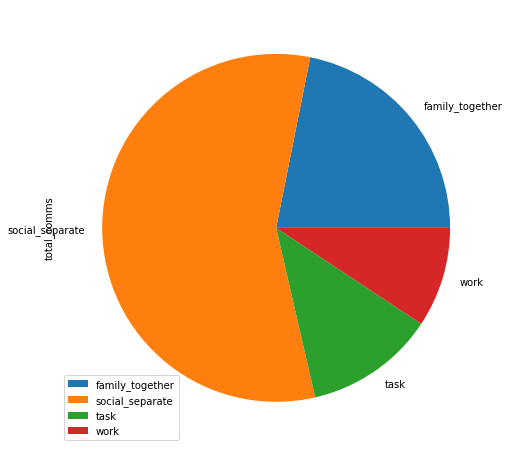

In [38]:
q4_df = top5_all_data.loc[top5_all_data['ego_age_q'] == 'age_q4']
q4_types = q4_df.drop_duplicates('combined_hash')
q4_groups = q4_types.groupby('contact_type').count()
q4_groups.plot.pie('total_comms', figsize=(8,8))
plt.legend(loc='lower left')

q4_pct = q4_groups['total_comms'] / q4_groups['total_comms'].sum() * 100
display(q4_pct)

In [104]:
age_q4_corrs = r_corrs[age_q4_idx]
age_q4_p_vals = r_p_vals[age_q4_idx]

age_q4_stats = np.transpose(np.vstack((age_q4_corrs, age_q4_p_vals)))
age_q4_df = pd.DataFrame(age_q4_stats, index=cols, columns=['corr', 'p'])
sig_features = age_q4_df.loc[age_q4_df['p'] < 0.05]
sig_features = sig_features.loc[~sig_features.index.isin([
    'age_q1',
    'age_q2',
    'age_q3',
    'age_q4',
    'ego_age'
])]
sig_features = sig_features.loc[~sig_features.index.str.startswith('ego')]
sig_features = sig_features.sort_values(by='p')
pd.options.display.float_format = '{:,.4f}'.format
display(sig_features)
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_6clf)])
#display(age_q4_df.loc[age_q4_df.index.isin(contact_types_4clf)])

,corr,p
out_sms_visit_reason:other,0.2321,0.0000
all_sms_visit_reason:other,0.2277,0.0000
call_tendency,0.1751,0.0000
all_sms_loc:home_nan_indicator,0.1565,0.0000
all_call_visit_reason:other,0.1557,0.0000
all_call_visit_reason:exercise,0.1504,0.0000
total_sms_days,-0.1432,0.0001
day_6_sms,-0.1427,0.0001
all_sms_visit_reason:entertainment_nan_indicator,0.1423,0.0001
std_out_sms_nan_indicator,0.1323,0.0004


#### q4 contact type correlations

In [105]:
q4_r_corrs, q4_r_p_vals, q4_cols = build_contact_corr(q4_df)

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_female". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_male". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "ego_gender_other". Fall back to string conversion. The error is: Cannot convert numpy array of unsigned values -- R does not have unsigned integers.
  (name, str(e)))
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/rpy2/robjects/pan

In [106]:
q4_ss_sig_df = get_sig_features(q4_cols, 'social_separate', q4_r_corrs, q4_r_p_vals, exclude_cols)
q4_ss_sig_df[:10]

,corr,p
missed_out_calls_nan_indicator,0.3013,0.0001
all_call_loc:home_nan_indicator,0.2836,0.0004
time_of_day_0_call_nan_indicator,0.2788,0.0006
all_call_visit_reason:entertainment_nan_indicator,0.2758,0.0007
min_out_call,-0.2746,0.0007
all_call_loc:shop,-0.2740,0.0007
reg_call,-0.2703,0.0009
avg_out_duration_nan_indicator,0.2681,0.0011
call_tendency,-0.2568,0.0020
time_of_day_0_call_dur_nan_indicator,0.2538,0.0024


In [107]:
q4_ft_sig_df = get_sig_features(q4_cols, 'family_together', q4_r_corrs, q4_r_p_vals, exclude_cols)
q4_ft_sig_df[:10]

,corr,p
all_call_loc:shop,0.4570,0.0000
reg_comm,0.4539,0.0000
reg_call,0.4380,0.0000
total_comm_days,0.4010,0.0000
total_call_days,0.3947,0.0000
mean_out_call,0.3472,0.0000
all_call_visit_reason:errand,0.3445,0.0000
total_calls,0.3206,0.0000
med_out_call,0.3027,0.0001
day_0_long_call_in,0.3022,0.0001


In [108]:
q4_w_sig_df = get_sig_features(q4_cols, 'work', q4_r_corrs, q4_r_p_vals, exclude_cols)
q4_w_sig_df[:10]

,corr,p
day_3_miss_call_in,0.2909,0.0003
time_of_day_1_miss_call_in,0.2904,0.0003
ego_race_black,0.2833,0.0004
day_2_call,0.2818,0.0005
all_sms_visit_reason:work,0.2800,0.0005
time_of_day_0_comm_out,0.2780,0.0006
time_of_day_2_miss_call_in,0.2660,0.0012
all_call_visit_reason:work,0.2655,0.0012
out_call_visit_reason:work,0.2602,0.0017
ego_race_white,-0.2584,0.0018


In [109]:
q4_t_sig_df = get_sig_features(q4_cols, 'task', q4_r_corrs, q4_r_p_vals, exclude_cols)
q4_t_sig_df[:10]

,corr,p
in_out_sms_nan_indicator,0.4236,0.0000
time_of_day_0_sms_nan_indicator,0.3646,0.0000
all_sms_loc:home_nan_indicator,0.3506,0.0000
all_sms_visit_reason:entertainment_nan_indicator,0.3426,0.0000
comm_last_2_wks,0.3069,0.0001
std_out_sms_nan_indicator,0.2844,0.0004
sms_last_6_wks,-0.2783,0.0006
std_in_sms_nan_indicator,0.2674,0.0011
total_comm_days,-0.2525,0.0026
call_tendency,0.2502,0.0029


### Quartile aggregation stats

In [51]:
allq_pct = pd.DataFrame()
allq_pct = allq_pct.append(q1_pct)
allq_pct = allq_pct.append(q2_pct)
allq_pct = allq_pct.append(q3_pct)
allq_pct = allq_pct.append(q4_pct)
allq_pct.columns = ['family together', 'social separate', 'task', 'work']
allq_pct.index = pd.Index(['Q1', 'Q2', 'Q3', 'Q4'])
display(allq_pct)
pd.options.display.float_format = '{:,.2f}%'.format
print(allq_pct.to_latex())

,family together,social separate,task,work
Q1,20.38%,67.31%,5.00%,7.31%
Q2,25.58%,56.74%,10.70%,6.98%
Q3,24.71%,58.43%,8.63%,8.24%
Q4,21.86%,56.74%,12.09%,9.30%


\begin{tabular}{lrrrr}
\toprule
{} &  family together &  social separate &   task &  work \\
\midrule
Q1 &           20.38\% &           67.31\% &  5.00\% & 7.31\% \\
Q2 &           25.58\% &           56.74\% & 10.70\% & 6.98\% \\
Q3 &           24.71\% &           58.43\% &  8.63\% & 8.24\% \\
Q4 &           21.86\% &           56.74\% & 12.09\% & 9.30\% \\
\bottomrule
\end{tabular}



## Random Forest: top 5 baseline features age subsets

In [12]:
rand_state = 2

### Q1

In [62]:
top5_base_q1_train_data = pickle.load(open("../data/subpop_features/top5_base_q1_train_features.df", "rb"))
top5_base_q1_test_data = pickle.load(open("../data/subpop_features/top5_base_q1_test_features.df", "rb"))
    
top5_base_q1_train_data = top5_base_q1_train_data.replace(replace_dict_4clf)
top5_base_q1_train_y = top5_base_q1_train_data['contact_type']
top5_base_q1_train_X = top5_base_q1_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q1_cols = top5_base_q1_train_X.columns.values
top5_base_q1_train_X = normalize(top5_base_q1_train_X)

top5_base_q1_test_data = top5_base_q1_test_data.replace(replace_dict_4clf)
top5_base_q1_test_y = top5_base_q1_test_data['contact_type']
top5_base_q1_test_X = top5_base_q1_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q1_test_X = normalize(top5_base_q1_test_X)

top5_base_q1_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q1_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q1_train_X, top5_base_q1_train_y, groups):
    top5_base_q1_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q1_train_X[fold_train_idx]
    fold_train_y = top5_base_q1_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q1_train_X[fold_test_idx]
    fold_test_y = top5_base_q1_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q1_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q1_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 141, 3: 141, 0: 141, 2: 141})
Counter({1: 138, 3: 138, 0: 138, 2: 138})
Counter({1: 137, 3: 137, 0: 137, 2: 137})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
[0.6363636363636364, 0.6545454545454545, 0.7, 0.64, 0.66]
0.6581818181818182


In [29]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q1_train_X, top5_base_q1_train_y)
#top5_base_q1_clf.fit(top5_base_q1_train_X, top5_base_q1_train_y)
top5_base_q1_clf.fit(X_res, y_res)
pred = top5_base_q1_clf.predict(top5_base_q1_test_X)
print_clf_metrics(top5_base_q1_test_y, pred, contact_types_4clf)

Accuracy: 0.5883211678832116


,precision,recall,F1
macro,0.517364,0.352450,0.368441
weighted,0.564940,0.588321,0.540256


,p_work,p_social,p_task,p_family_together
work,5,47,1,3
social,9,331,3,50
task,1,56,9,5
family_together,1,105,1,58


,precision,recall,F1
macro,0.517364,0.352450,0.368441
weighted,0.564940,0.588321,0.540256


In [40]:
importances = top5_base_q1_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q1_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_5_comm,0.025194
time_of_day_2_comm,0.022479
day_5_sms,0.018863
time_of_day_5_call,0.017015
comm_last_2_wks,0.014753
time_of_day_0_comm,0.014229
time_of_day_3_comm,0.013444
time_of_day_5_call_dur,0.013109
reg_sms,0.012715
day_0_sms,0.012536


### Q2

In [63]:
top5_base_q2_train_data = pickle.load(open("../data/subpop_features/top5_base_q2_train_features.df", "rb"))
top5_base_q2_test_data = pickle.load(open("../data/subpop_features/top5_base_q2_test_features.df", "rb"))
    
top5_base_q2_train_data = top5_base_q2_train_data.replace(replace_dict_4clf)
top5_base_q2_train_y = top5_base_q2_train_data['contact_type']
top5_base_q2_train_X = top5_base_q2_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q2_cols = top5_base_q2_train_X.columns.values
top5_base_q2_train_X = normalize(top5_base_q2_train_X)

top5_base_q2_test_data = top5_base_q2_test_data.replace(replace_dict_4clf)
top5_base_q2_test_y = top5_base_q2_test_data['contact_type']
top5_base_q2_test_X = top5_base_q2_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q2_test_X = normalize(top5_base_q2_test_X)

top5_base_q2_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q2_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q2_train_X, top5_base_q2_train_y, groups):
    top5_base_q2_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q2_train_X[fold_train_idx]
    fold_train_y = top5_base_q2_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q2_train_X[fold_test_idx]
    fold_test_y = top5_base_q2_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q2_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q2_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({2: 102, 1: 102, 3: 102, 0: 102})
Counter({2: 95, 1: 95, 3: 95, 0: 95})
Counter({3: 91, 1: 91, 0: 91, 2: 91})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
[0.6222222222222222, 0.5555555555555556, 0.6888888888888889, 0.65, 0.625]
0.6283333333333333


In [31]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q2_train_X, top5_base_q2_train_y)
#top5_base_q2_clf.fit(top5_base_q2_train_X, top5_base_q2_train_y)
top5_base_q2_clf.fit(X_res, y_res)
pred = top5_base_q2_clf.predict(top5_base_q2_test_X)
print_clf_metrics(top5_base_q2_test_y, pred, contact_types_4clf)

Accuracy: 0.6246575342465753


,precision,recall,F1
macro,0.455670,0.414040,0.422086
weighted,0.587506,0.624658,0.599138


,p_work,p_social,p_task,p_family_together
work,4,42,7,7
social,10,362,17,57
task,2,30,22,7
family_together,2,86,7,68


,precision,recall,F1
macro,0.455670,0.414040,0.422086
weighted,0.587506,0.624658,0.599138


In [43]:
importances = top5_base_q2_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q2_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
comm_last_6_wks,0.019477
day_1_comm,0.018000
day_2_comm,0.017775
day_4_long_call_out,0.015665
out_comm,0.015328
mean_out_sms,0.015023
total_comms,0.014968
time_of_day_5_sms,0.014705
day_0_comm,0.014656
comm_last_2_wks,0.014579


### Q3

In [64]:
top5_base_q3_train_data = pickle.load(open("../data/subpop_features/top5_base_q3_train_features.df", "rb"))
top5_base_q3_test_data = pickle.load(open("../data/subpop_features/top5_base_q3_test_features.df", "rb"))
    
top5_base_q3_train_data = top5_base_q3_train_data.replace(replace_dict_4clf)
top5_base_q3_train_y = top5_base_q3_train_data['contact_type']
top5_base_q3_train_X = top5_base_q3_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q3_cols = top5_base_q3_train_X.columns.values
top5_base_q3_train_X = normalize(top5_base_q3_train_X)

top5_base_q3_test_data = top5_base_q3_test_data.replace(replace_dict_4clf)
top5_base_q3_test_y = top5_base_q3_test_data['contact_type']
top5_base_q3_test_X = top5_base_q3_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q3_test_X = normalize(top5_base_q3_test_X)

top5_base_q3_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q3_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q3_train_X, top5_base_q3_train_y, groups):
    top5_base_q3_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q3_train_X[fold_train_idx]
    fold_train_y = top5_base_q3_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q3_train_X[fold_test_idx]
    fold_test_y = top5_base_q3_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q3_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q3_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({3: 118, 1: 118, 2: 118, 0: 118})
Counter({1: 120, 3: 120, 2: 120, 0: 120})
Counter({1: 118, 3: 118, 0: 118, 2: 118})
Counter({1: 116, 3: 116, 2: 116, 0: 116})
Counter({1: 124, 3: 124, 2: 124, 0: 124})
[0.5272727272727272, 0.56, 0.6, 0.6, 0.56]
0.5694545454545455


In [34]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q3_train_X, top5_base_q3_train_y)
#top5_base_q3_clf.fit(top5_base_q3_train_X, top5_base_q3_train_y)
top5_base_q3_clf.fit(X_res, y_res)
pred = top5_base_q3_clf.predict(top5_base_q3_test_X)
print_clf_metrics(top5_base_q3_test_y, pred, contact_types_4clf)

Accuracy: 0.6420289855072464


,precision,recall,F1
macro,0.503565,0.431139,0.449568
weighted,0.603693,0.642029,0.611547


,p_work,p_social,p_task,p_family_together
work,4,44,0,6
social,9,355,14,41
task,1,24,27,10
family_together,3,90,5,57


,precision,recall,F1
macro,0.503565,0.431139,0.449568
weighted,0.603693,0.642029,0.611547


In [45]:
importances = top5_base_q3_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q3_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
time_of_day_4_comm_out,0.028062
in_out_sms,0.024481
time_of_day_5_comm,0.019158
mean_out_sms,0.017290
time_of_day_4_call_dur,0.016039
max_out_sms,0.015719
med_out_sms,0.014407
std_out_sms,0.013889
total_sms_days,0.013441
total_calls,0.013373


### Q4

In [65]:
top5_base_q4_train_data = pickle.load(open("../data/subpop_features/top5_base_q4_train_features.df", "rb"))
top5_base_q4_test_data = pickle.load(open("../data/subpop_features/top5_base_q4_test_features.df", "rb"))
    
top5_base_q4_train_data = top5_base_q4_train_data.replace(replace_dict_4clf)
top5_base_q4_train_y = top5_base_q4_train_data['contact_type']
top5_base_q4_train_X = top5_base_q4_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q4_cols = top5_base_q4_train_X.columns.values
top5_base_q4_train_X = normalize(top5_base_q4_train_X)

top5_base_q4_test_data = top5_base_q4_test_data.replace(replace_dict_4clf)
top5_base_q4_test_y = top5_base_q4_test_data['contact_type']
top5_base_q4_test_X = top5_base_q4_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_base_q4_test_X = normalize(top5_base_q4_test_X)

top5_base_q4_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_base_q4_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_base_q4_train_X, top5_base_q4_train_y, groups):
    top5_base_q4_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_base_q4_train_X[fold_train_idx]
    fold_train_y = top5_base_q4_train_y.values[fold_train_idx]
    fold_test_X = top5_base_q4_train_X[fold_test_idx]
    fold_test_y = top5_base_q4_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_base_q4_clf.fit(fold_train_X, fold_train_y)
    predict = top5_base_q4_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 94, 2: 94, 0: 94, 3: 94})
Counter({1: 100, 2: 100, 0: 100, 3: 100})
Counter({0: 85, 3: 85, 1: 85, 2: 85})
Counter({1: 102, 2: 102, 0: 102, 3: 102})
Counter({1: 107, 2: 107, 3: 107, 0: 107})
[0.4666666666666667, 0.6666666666666666, 0.7111111111111111, 0.5, 0.5]
0.5688888888888889


In [66]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_base_q4_train_X, top5_base_q4_train_y)
#top5_base_q4_clf.fit(top5_base_q4_train_X, top5_base_q4_train_y)
top5_base_q4_clf.fit(X_res, y_res)
pred = top5_base_q4_clf.predict(top5_base_q4_test_X)
print_clf_metrics(top5_base_q4_test_y, pred, contact_types_4clf)

Accuracy: 0.6506849315068494


,precision,recall,F1
macro,0.519848,0.429451,0.452711
weighted,0.617493,0.650685,0.622608


,p_work,p_social,p_task,p_family_together
work,4,47,2,2
social,7,374,10,55
task,2,31,21,4
family_together,3,89,3,76


,precision,recall,F1
macro,0.519848,0.429451,0.452711
weighted,0.617493,0.650685,0.622608


In [48]:
importances = top5_base_q4_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_base_q4_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
med_out_sms,0.025628
in_out_sms_nan_indicator,0.020123
mean_out_sms,0.019721
max_out_sms,0.019173
time_of_day_5_comm,0.016918
time_of_day_5_comm_out,0.016407
sms_last_6_wks,0.015913
std_out_sms,0.014724
time_of_day_5_call,0.013471
time_of_day_0_sms_nan_indicator,0.012568


## Random Forest: top 5 all features age subsets

### Q1

In [50]:
top5_all_q1_train_data = pickle.load(open("../data/subpop_features/top5_all_q1_train_features.df", "rb"))
top5_all_q1_test_data = pickle.load(open("../data/subpop_features/top5_all_q1_test_features.df", "rb"))
    
top5_all_q1_train_data = top5_all_q1_train_data.replace(replace_dict_4clf)
top5_all_q1_train_y = top5_all_q1_train_data['contact_type']
top5_all_q1_train_X = top5_all_q1_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q1_cols = top5_all_q1_train_X.columns.values
top5_all_q1_train_X = normalize(top5_all_q1_train_X)

top5_all_q1_test_data = top5_all_q1_test_data.replace(replace_dict_4clf)
top5_all_q1_test_y = top5_all_q1_test_data['contact_type']
top5_all_q1_test_X = top5_all_q1_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q1_test_X = normalize(top5_all_q1_test_X)

top5_all_q1_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q1_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q1_train_X, top5_all_q1_train_y, groups):
    top5_all_q1_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q1_train_X[fold_train_idx]
    fold_train_y = top5_all_q1_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q1_train_X[fold_test_idx]
    fold_test_y = top5_all_q1_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q1_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q1_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 141, 3: 141, 0: 141, 2: 141})
Counter({1: 138, 3: 138, 0: 138, 2: 138})
Counter({1: 137, 3: 137, 0: 137, 2: 137})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
Counter({1: 142, 3: 142, 0: 142, 2: 142})
[0.6181818181818182, 0.6909090909090909, 0.7, 0.66, 0.68]
0.6698181818181819


In [51]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q1_train_X, top5_all_q1_train_y)
#top5_all_q1_clf.fit(top5_all_q1_train_X, top5_all_q1_train_y)
top5_all_q1_clf.fit(X_res, y_res)
pred = top5_all_q1_clf.predict(top5_all_q1_test_X)
print_clf_metrics(top5_all_q1_test_y, pred, contact_types_4clf)

Accuracy: 0.5941605839416059


,precision,recall,F1
macro,0.604833,0.334600,0.343225
weighted,0.596563,0.594161,0.529817


,p_work,p_social,p_task,p_family_together
work,4,51,0,1
social,3,348,0,42
task,0,61,6,4
family_together,2,113,1,49


,precision,recall,F1
macro,0.604833,0.334600,0.343225
weighted,0.596563,0.594161,0.529817


In [52]:
importances = top5_all_q1_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q1_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_0_comm_out,0.021391
time_of_day_2_sms,0.017757
day_5_comm,0.016163
time_of_day_3_comm,0.015754
time_of_day_0_miss_call_out_nan_indicator,0.014721
ego_age,0.014111
ego_employment_employed,0.013253
all_sms_loc:work,0.013180
out_comm,0.012359
total_comm_days,0.011009


### Q2

In [53]:
top5_all_q2_train_data = pickle.load(open("../data/subpop_features/top5_all_q2_train_features.df", "rb"))
top5_all_q2_test_data = pickle.load(open("../data/subpop_features/top5_all_q2_test_features.df", "rb"))
    
top5_all_q2_train_data = top5_all_q2_train_data.replace(replace_dict_4clf)
top5_all_q2_train_y = top5_all_q2_train_data['contact_type']
top5_all_q2_train_X = top5_all_q2_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q2_cols = top5_all_q2_train_X.columns.values
top5_all_q2_train_X = normalize(top5_all_q2_train_X)

top5_all_q2_test_data = top5_all_q2_test_data.replace(replace_dict_4clf)
top5_all_q2_test_y = top5_all_q2_test_data['contact_type']
top5_all_q2_test_X = top5_all_q2_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q2_test_X = normalize(top5_all_q2_test_X)

top5_all_q2_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q2_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q2_train_X, top5_all_q2_train_y, groups):
    top5_all_q2_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q2_train_X[fold_train_idx]
    fold_train_y = top5_all_q2_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q2_train_X[fold_test_idx]
    fold_test_y = top5_all_q2_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q2_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q2_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({2: 102, 1: 102, 3: 102, 0: 102})
Counter({2: 95, 1: 95, 3: 95, 0: 95})
Counter({3: 91, 1: 91, 0: 91, 2: 91})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
Counter({2: 100, 1: 100, 3: 100, 0: 100})
[0.6444444444444445, 0.6222222222222222, 0.7333333333333333, 0.7, 0.55]
0.65


In [54]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q2_train_X, top5_all_q2_train_y)
#top5_all_q2_clf.fit(top5_all_q2_train_X, top5_all_q2_train_y)
top5_all_q2_clf.fit(X_res, y_res)
pred = top5_all_q2_clf.predict(top5_all_q2_test_X)
print_clf_metrics(top5_all_q2_test_y, pred, contact_types_4clf)

Accuracy: 0.6438356164383562


,precision,recall,F1
macro,0.481830,0.411824,0.425458
weighted,0.599436,0.643836,0.609815


,p_work,p_social,p_task,p_family_together
work,3,46,4,7
social,6,381,10,49
task,2,28,21,10
family_together,2,89,7,65


,precision,recall,F1
macro,0.481830,0.411824,0.425458
weighted,0.599436,0.643836,0.609815


In [55]:
importances = top5_all_q2_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q2_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
day_0_comm,0.014703
comm_last_2_wks,0.013468
ego_age,0.013281
day_2_comm,0.013258
comm_last_6_wks,0.011368
ego_employment_employed,0.010934
all_sms_visit_reason:home,0.010852
time_of_day_2_sms,0.010748
tot_call_duration,0.010714
day_3_comm,0.010673


### Q3

In [56]:
top5_all_q3_train_data = pickle.load(open("../data/subpop_features/top5_all_q3_train_features.df", "rb"))
top5_all_q3_test_data = pickle.load(open("../data/subpop_features/top5_all_q3_test_features.df", "rb"))
    
top5_all_q3_train_data = top5_all_q3_train_data.replace(replace_dict_4clf)
top5_all_q3_train_y = top5_all_q3_train_data['contact_type']
top5_all_q3_train_X = top5_all_q3_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q3_cols = top5_all_q3_train_X.columns.values
top5_all_q3_train_X = normalize(top5_all_q3_train_X)

top5_all_q3_test_data = top5_all_q3_test_data.replace(replace_dict_4clf)
top5_all_q3_test_y = top5_all_q3_test_data['contact_type']
top5_all_q3_test_X = top5_all_q3_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q3_test_X = normalize(top5_all_q3_test_X)

top5_all_q3_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q3_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q3_train_X, top5_all_q3_train_y, groups):
    top5_all_q3_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q3_train_X[fold_train_idx]
    fold_train_y = top5_all_q3_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q3_train_X[fold_test_idx]
    fold_test_y = top5_all_q3_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q3_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q3_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({3: 118, 1: 118, 2: 118, 0: 118})
Counter({1: 120, 3: 120, 2: 120, 0: 120})
Counter({1: 118, 3: 118, 0: 118, 2: 118})
Counter({1: 116, 3: 116, 2: 116, 0: 116})
Counter({1: 124, 3: 124, 2: 124, 0: 124})
[0.5454545454545454, 0.58, 0.64, 0.66, 0.58]
0.6010909090909091


In [57]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q3_train_X, top5_all_q3_train_y)
#top5_all_q3_clf.fit(top5_all_q3_train_X, top5_all_q3_train_y)
top5_all_q3_clf.fit(X_res, y_res)
pred = top5_all_q3_clf.predict(top5_all_q3_test_X)
print_clf_metrics(top5_all_q3_test_y, pred, contact_types_4clf)

Accuracy: 0.6550724637681159


,precision,recall,F1
macro,0.517094,0.431460,0.453036
weighted,0.616903,0.655072,0.619580


,p_work,p_social,p_task,p_family_together
work,3,42,2,7
social,12,366,11,30
task,1,30,27,4
family_together,1,95,3,56


,precision,recall,F1
macro,0.517094,0.431460,0.453036
weighted,0.616903,0.655072,0.619580


In [58]:
importances = top5_all_q3_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q3_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
mean_out_sms,0.016040
time_of_day_4_comm_out,0.013897
in_out_sms,0.013846
time_of_day_4_comm,0.013149
time_of_day_4_call_dur,0.012262
med_out_sms,0.011625
total_sms_days,0.011616
out_sms_loc:work,0.011438
std_out_sms,0.009395
time_of_day_5_comm,0.009197


### Q4

In [59]:
top5_all_q4_train_data = pickle.load(open("../data/subpop_features/top5_all_q4_train_features.df", "rb"))
top5_all_q4_test_data = pickle.load(open("../data/subpop_features/top5_all_q4_test_features.df", "rb"))
    
top5_all_q4_train_data = top5_all_q4_train_data.replace(replace_dict_4clf)
top5_all_q4_train_y = top5_all_q4_train_data['contact_type']
top5_all_q4_train_X = top5_all_q4_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q4_cols = top5_all_q4_train_X.columns.values
top5_all_q4_train_X = normalize(top5_all_q4_train_X)

top5_all_q4_test_data = top5_all_q4_test_data.replace(replace_dict_4clf)
top5_all_q4_test_y = top5_all_q4_test_data['contact_type']
top5_all_q4_test_X = top5_all_q4_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
top5_all_q4_test_X = normalize(top5_all_q4_test_X)

top5_all_q4_clf = RandomForestClassifier(random_state=rand_state, n_jobs=4, n_estimators=100, warm_start=False)

groups = build_cv_groups(top5_all_q4_train_data['pid'])
#group_kfold = GroupKFold(n_splits=len(set(groups)))
group_kfold_res = GroupKFoldSample(n_splits=5, random_state=rand_state)

cv_scores = []
for fold_train_idx, fold_test_idx in group_kfold_res.split(top5_all_q4_train_X, top5_all_q4_train_y, groups):
    top5_all_q4_clf = RandomForestClassifier(random_state=2, n_jobs=4, n_estimators=100, warm_start=False)
    fold_train_X = top5_all_q4_train_X[fold_train_idx]
    fold_train_y = top5_all_q4_train_y.values[fold_train_idx]
    fold_test_X = top5_all_q4_train_X[fold_test_idx]
    fold_test_y = top5_all_q4_train_y.values[fold_test_idx]
    
    print(Counter(fold_train_y))
    top5_all_q4_clf.fit(fold_train_X, fold_train_y)
    predict = top5_all_q4_clf.predict(fold_test_X)
    cv_scores.append(accuracy_score(fold_test_y, predict))
print(cv_scores)    
print(np.mean(cv_scores))

Counter({1: 94, 2: 94, 0: 94, 3: 94})
Counter({1: 100, 2: 100, 0: 100, 3: 100})
Counter({0: 85, 3: 85, 1: 85, 2: 85})
Counter({1: 102, 2: 102, 0: 102, 3: 102})
Counter({1: 107, 2: 107, 3: 107, 0: 107})
[0.4666666666666667, 0.6222222222222222, 0.7333333333333333, 0.5, 0.5]
0.5644444444444445


In [60]:
rs = RandomOverSampler(random_state=rand_state)
X_res, y_res = rs.fit_resample(top5_all_q4_train_X, top5_all_q4_train_y)
#top5_all_q4_clf.fit(top5_all_q4_train_X, top5_all_q4_train_y)
top5_all_q4_clf.fit(X_res, y_res)
pred = top5_all_q4_clf.predict(top5_all_q4_test_X)
print_clf_metrics(top5_all_q4_test_y, pred, contact_types_4clf)

Accuracy: 0.6506849315068494


,precision,recall,F1
macro,0.481406,0.401884,0.416580
weighted,0.601024,0.650685,0.610702


,p_work,p_social,p_task,p_family_together
work,1,45,3,6
social,2,388,8,48
task,3,32,19,4
family_together,1,99,4,67


,precision,recall,F1
macro,0.481406,0.401884,0.416580
weighted,0.601024,0.650685,0.610702


In [61]:
importances = top5_all_q4_clf.feature_importances_
imp_df = pd.DataFrame(importances, index=top5_all_q4_cols, columns=['imp'])
display(imp_df.sort_values('imp', ascending=False)[:10])

,imp
mean_out_sms,0.020111
in_out_sms_nan_indicator,0.019749
med_out_sms,0.018101
max_out_sms,0.014945
std_out_sms,0.013375
time_of_day_5_comm_out,0.011221
reg_sms,0.010781
std_out_sms_nan_indicator,0.009747
total_sms,0.009604
total_sms_days,0.009601


## AutoML: all quartiles results

In [117]:
subpop_data_dir = "/home/tliu/relationship-prediction/data/subpop_features/"
subpop_results_dir = "/home/tliu/relationship-prediction/model/subpop_results/"
allq_s4_test_data = pickle.load(open(subpop_data_dir + "top5_all_allq_s4_test_features.df", "rb"))
# allq_s4_base_preds = pickle.load(open(subpop_results_dir + "allq_s4_base.predict", "rb"))
# allq_s4_all_preds = pickle.load(open(subpop_results_dir + "allq_s4_all.predict", "rb"))
# allq_s3_test_data = allq_s3_test_data.replace(replace_dict_4clf)
# allq_s3_test_y = allq_s3_test_data['contact_type']
# print_clf_metrics(allq_s3_test_y, allq_s3_base_preds, contact_types_4clf)

In [118]:
import warnings
warnings.filterwarnings('ignore')

# get the test pids used in allq
def get_q_results(model_names, predict_name, include_pids):
    """Builds a df of model performance, split by quartile.
    
    Args:
        model_names (list): a list of the model name prefixes to add to table
        predict_name (str): the predict file name format, eg 4clf/{model_name}_all.predict
        include_pids (list): a list of the pids to include when evaluating quartile performance
    Returns:
        pandas.DataFrame: rows are each model, columns are macro, weighted F1 perf on each quartile
    """
    subpop_data_dir = "/home/tliu/relationship-prediction/data/subpop_features/"
    subpop_results_dir = "/home/tliu/relationship-prediction/model/subpop_results/"

    results_mat = np.zeros((len(model_names)+1,12))

    result_cols = []
    for i in range(1,5):
        result_cols.append("q{} macro f1".format(i))
        result_cols.append("q{} micro f1".format(i))
        result_cols.append("q{} weighted f1".format(i))
        # for better latex formatting
#         result_cols.append("macro F1".format(i))
#         result_cols.append("weight F1".format(i))
        
    model_names = ['majority'] + model_names
    
    # loop over predictions per model
    for i, model in enumerate(model_names):
        if model == 'majority':
            # grab the test data for the allq model
            q_test_data = pickle.load(open(subpop_data_dir + "top5_all_{}_test_features.df".format(model_names[-1]), "rb"))
            # 1 == social separate, the majority class
            q_preds = np.array([1] * q_test_data.shape[0])
        else:
            q_test_data = pickle.load(open(subpop_data_dir + "top5_all_{}_test_features.df".format(model), "rb"))
            q_preds = pickle.load(open(subpop_results_dir + predict_name.format(model), "rb"))
        q_test_data = q_test_data.replace(replace_dict_4clf)
        # create index column to align with predictions
        q_test_data['idx'] = range(len(q_test_data))

        # loop over test predictions for each quartile
        for q in range(1,5):
            if (q) != i:
                sel_test_data = q_test_data.loc[q_test_data['pid'].isin(test_pids)]
                sel_test_data = sel_test_data[sel_test_data['ego_age_q'] == "age_q{}".format(q)]
                pid_idx = sel_test_data['idx'].values
                #pid_idx = np.argwhere(np.array(q_test_data['ego_age_q'].values) == "age_q{}".format(q)).squeeze()
                sel_preds = q_preds[pid_idx]
                sel_y = q_test_data['contact_type'].values[pid_idx]
                results_mat[i, (3*(q-1))] = f1_score(sel_y, sel_preds, average='macro')
                #results_mat[i, (3*(q-1))+1] = f1_score(sel_y, sel_preds, average='micro')
                results_mat[i, (3*(q-1))+1] = accuracy_score(sel_y, sel_preds)
                results_mat[i, (3*(q-1))+2] = f1_score(sel_y, sel_preds, average='weighted')
                #print_clf_metrics(sel_y, sel_preds, contact_types_4clf)
            else:
                results_mat[i, (3*(q-1))] = 0
                results_mat[i, (3*(q-1))+1] = 0
                results_mat[i, (3*(q-1))+2] = 0


    perf_df = pd.DataFrame(results_mat, index=model_names, columns=result_cols)
    return perf_df

### Weighted F1

In [119]:
allq_s4_test_data = pickle.load(open(subpop_data_dir + "top5_all_allq_s4_test_features.df", "rb"))
allq_s4_train_data = pickle.load(open(subpop_data_dir + "top5_all_allq_s4_train_features.df", "rb"))

allq_s4_all_data = allq_s4_test_data.append(allq_s4_train_data)
test_pids = allq_s4_all_data['pid'].unique()
print(len(test_pids))
# for i in range(1,5):
#     test_pids.extend(allq_s4_test_data.loc[allq_s4_test_data['ego_age_q'] == ('age_q' + str(i))]['pid'].unique())
model_names = ['q1', 'q2', 'q3', 'q4']
for i in range(10):
    model_names.append("allq_s{}".format(i))
    
predict_name = "4clf/{}_all.predict"

weighted_df = get_q_results(model_names, predict_name, test_pids)
weighted_df = weighted_df.loc[:, weighted_df.columns.str.contains('weighted')]
weighted_df = weighted_df.round(3)
display(weighted_df)

allq_df = weighted_df.loc[weighted_df.index.str.contains('allq'), :]
display(allq_df.mean(axis=0))
display(allq_df.std(axis=0))

189


,q1 weighted f1,q2 weighted f1,q3 weighted f1,q4 weighted f1
majority,0.5180,0.4040,0.4500,0.4190
q1,0.0000,0.5070,0.5690,0.5190
q2,0.6420,0.0000,0.5670,0.5850
q3,0.6580,0.6480,0.0000,0.6230
q4,0.6330,0.5970,0.6100,0.0000
allq_s0,0.6500,0.6430,0.5720,0.6140
allq_s1,0.6630,0.6240,0.5520,0.6170
allq_s2,0.6230,0.6580,0.5910,0.6110
allq_s3,0.6340,0.6090,0.5960,0.5440
allq_s4,0.6390,0.5740,0.5650,0.5790


q1 weighted f1   0.6473
q2 weighted f1   0.6097
q3 weighted f1   0.5826
q4 weighted f1   0.6058
dtype: float64

q1 weighted f1   0.0182
q2 weighted f1   0.0343
q3 weighted f1   0.0185
q4 weighted f1   0.0416
dtype: float64

### Micro F1

In [32]:
allq_s4_test_data = pickle.load(open(subpop_data_dir + "top5_all_allq_s4_test_features.df", "rb"))
allq_s4_train_data = pickle.load(open(subpop_data_dir + "top5_all_allq_s4_train_features.df", "rb"))

allq_s4_all_data = allq_s4_test_data.append(allq_s4_train_data)
test_pids = allq_s4_all_data['pid'].unique()
print(len(test_pids))
# for i in range(1,5):
#     test_pids.extend(allq_s4_test_data.loc[allq_s4_test_data['ego_age_q'] == ('age_q' + str(i))]['pid'].unique())
model_names = ['q1', 'q2', 'q3', 'q4']
for i in range(10):
    model_names.append("allq_s{}".format(i))
    
predict_name = "micro/{}_all_micro.predict"

micro_df = get_q_results(model_names, predict_name, test_pids)
micro_df = micro_df.loc[:, micro_df.columns.str.contains('micro')]
micro_df = micro_df.round(3)
display(micro_df)

allq_df = micro_df.loc[micro_df.index.str.contains('allq'), :]
q_micro_df = micro_df.loc[~micro_df.index.str.contains('allq'), :]

display(allq_df.mean(axis=0))
display(allq_df.std(axis=0))

print(q_micro_df.to_latex())

189


,q1 micro f1,q2 micro f1,q3 micro f1,q4 micro f1
majority,0.655,0.561,0.600,0.574
q1,0.000,0.600,0.600,0.586
q2,0.700,0.000,0.631,0.605
q3,0.692,0.651,0.000,0.651
q4,0.665,0.628,0.671,0.000
allq_s0,0.695,0.632,0.600,0.626
allq_s1,0.720,0.652,0.564,0.645
allq_s2,0.655,0.613,0.590,0.652
allq_s3,0.680,0.594,0.610,0.574
allq_s4,0.655,0.613,0.569,0.581


q1 micro f1    0.6830
q2 micro f1    0.6278
q3 micro f1    0.6000
q4 micro f1    0.6284
dtype: float64

q1 micro f1    0.025626
q2 micro f1    0.018749
q3 micro f1    0.026281
q4 micro f1    0.041237
dtype: float64

\begin{tabular}{lrrrr}
\toprule
{} &  q1 micro f1 &  q2 micro f1 &  q3 micro f1 &  q4 micro f1 \\
\midrule
majority &        0.655 &        0.561 &        0.600 &        0.574 \\
q1       &        0.000 &        0.600 &        0.600 &        0.586 \\
q2       &        0.700 &        0.000 &        0.631 &        0.605 \\
q3       &        0.692 &        0.651 &        0.000 &        0.651 \\
q4       &        0.665 &        0.628 &        0.671 &        0.000 \\
\bottomrule
\end{tabular}



### Macro F1

In [22]:
macro_predict_name = "macro/{}_all_macro.predict"
model_names = ['q1', 'q2', 'q3', 'q4']
for i in range(10):
    model_names.append("allq_s{}".format(i))
macro_df = get_q_results(model_names, macro_predict_name, test_pids)
macro_df = macro_df.loc[:, macro_df.columns.str.contains('macro')]
display(macro_df)

allq_df = macro_df.loc[weighted_df.index.str.contains('allq'), :]
display(allq_df.mean(axis=0))
display(allq_df.std(axis=0))

,q1 macro f1,q2 macro f1,q3 macro f1,q4 macro f1
majority,0.197885,0.179752,0.187500,0.182377
q1,0.000000,0.312268,0.375295,0.392463
q2,0.395989,0.000000,0.443616,0.465446
q3,0.302874,0.438875,0.000000,0.493945
q4,0.338385,0.445500,0.424121,0.000000
allq_s0,0.432253,0.463030,0.437759,0.497775
allq_s1,0.415763,0.458583,0.416722,0.488912
allq_s2,0.399820,0.460888,0.465009,0.486613
allq_s3,0.346879,0.504624,0.421561,0.471924
allq_s4,0.404349,0.465926,0.455922,0.455982


q1 macro f1    0.387714
q2 macro f1    0.468196
q3 macro f1    0.424991
q4 macro f1    0.487272
dtype: float64

q1 macro f1    0.038916
q2 macro f1    0.020951
q3 macro f1    0.021998
q4 macro f1    0.041453
dtype: float64

### Accuracy

In [34]:
acc_predict_name = "acc/{}_all_acc.predict"
model_names = ['q1', 'q2', 'q3', 'q4']
for i in range(10):
    model_names.append("allq_s{}".format(i))
acc_df = get_q_results(model_names, acc_predict_name, test_pids)
acc_df = acc_df.loc[:, acc_df.columns.str.contains('micro')]
display(acc_df)

allq_df = acc_df.loc[weighted_df.index.str.contains('allq'), :]
display(allq_df.mean(axis=0))
display(allq_df.std(axis=0))

,q1 micro f1,q2 micro f1,q3 micro f1,q4 micro f1
majority,0.655000,0.561290,0.600000,0.574194
q1,0.000000,0.595349,0.607843,0.567442
q2,0.715385,0.000000,0.654902,0.623256
q3,0.676923,0.660465,0.000000,0.655814
q4,0.630769,0.627907,0.623529,0.000000
allq_s0,0.695000,0.619355,0.584615,0.625806
allq_s1,0.710000,0.664516,0.579487,0.651613
allq_s2,0.670000,0.612903,0.620513,0.632258
allq_s3,0.670000,0.606452,0.600000,0.567742
allq_s4,0.680000,0.619355,0.584615,0.593548


q1 micro f1    0.690000
q2 micro f1    0.621935
q3 micro f1    0.601538
q4 micro f1    0.618710
dtype: float64

q1 micro f1    0.013744
q2 micro f1    0.025663
q3 micro f1    0.025817
q4 micro f1    0.039238
dtype: float64

In [99]:
print(macro_df.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  q1 macro f1 &  q2 macro f1 &  q3 macro f1 &  q4 macro f1 \\
\midrule
majority &        0.205 &        0.174 &        0.183 &        0.184 \\
q1       &        0.000 &        0.315 &        0.386 &        0.349 \\
q2       &        0.353 &        0.000 &        0.426 &        0.456 \\
q3       &        0.312 &        0.450 &        0.000 &        0.443 \\
q4       &        0.321 &        0.455 &        0.397 &        0.000 \\
allq\_s4  &        0.404 &        0.466 &        0.456 &        0.456 \\
\bottomrule
\end{tabular}



## Sandbox

### LOOCV

In [3]:
subpop_results_dir = "/home/tliu/relationship-prediction/model/subpop_results/"
subpop_data_dir = "/home/tliu/relationship-prediction/data/subpop_features/"

predict_targets = [
    'contact_type',
    'q1_want',
    'q2_talk',
    'q3_loan',
    'q4_closeness',
    'tie_str_score',
    'tie_str_rank',
    'tie_str_class',
    'ego_age_q'
]
rand_state = 2

In [5]:
def get_loocv_results(in_data, model):
    in_data = in_data.replace(replace_dict_4clf)
    pids = in_data['pid'].unique()
    loocv_preds = []
    actual_y = []
    for pid in pids:
        train_X = in_data.loc[in_data['pid'] != pid].drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')
        test_X = in_data.loc[in_data['pid'] == pid].drop(['pid', 'combined_hash'] + predict_targets, axis=1, errors='ignore')

        train_y = in_data.loc[in_data['pid'] != pid]['contact_type']
        test_y = in_data.loc[in_data['pid'] == pid]['contact_type']
        #rs = RandomOverSampler(random_state=rand_state)
        #X_res, y_res = rs.fit_resample(train_X, train_y)
        #%time model.refit(X_res, y_res)
        %time model.refit(train_X.copy(), train_y.copy())
        loocv_preds.extend(model.predict(test_X))
        actual_y.extend(test_y)
    
    return loocv_preds, actual_y

### LOOCV weighted F1

In [11]:
%xdel q1_all_model
%xdel q2_all_model
%xdel q3_all_model
%xdel q4_all_model

NameError: name 'q1_all_model' is not defined
NameError: name 'q2_all_model' is not defined
NameError: name 'q3_all_model' is not defined
NameError: name 'q4_all_model' is not defined


In [ ]:
q1_train_data = pickle.load(open(subpop_data_dir + "top5_all_q1_train_features.df", "rb"))
q1_all_model = pickle.load(open(subpop_results_dir + "4clf/q1_all.automl", "rb"))
q1_preds, q1_y = get_loocv_results(q1_train_data, q1_all_model)

In [13]:
f1_score(q1_y, q1_preds, average='weighted')

/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6237924865831843

In [17]:
q2_train_data = pickle.load(open(subpop_data_dir + "top5_all_q2_train_features.df", "rb"))
q2_all_model = pickle.load(open(subpop_results_dir + "4clf/q2_all.automl", "rb"))
q2_preds, q2_y = get_loocv_results(q2_train_data, q2_all_model)

CPU times: user 33.6 s, sys: 4.94 s, total: 38.6 s
Wall time: 38.7 s
CPU times: user 32 s, sys: 5.28 s, total: 37.2 s
Wall time: 37.8 s
CPU times: user 30.9 s, sys: 5.1 s, total: 36 s
Wall time: 37.4 s
CPU times: user 23 s, sys: 4.58 s, total: 27.6 s
Wall time: 28.2 s
CPU times: user 21.3 s, sys: 4.4 s, total: 25.7 s
Wall time: 26 s
CPU times: user 21.1 s, sys: 4.28 s, total: 25.4 s
Wall time: 25.4 s
CPU times: user 20.7 s, sys: 4.14 s, total: 24.8 s
Wall time: 24.8 s
CPU times: user 20.7 s, sys: 4.32 s, total: 25.1 s
Wall time: 25.1 s
CPU times: user 20.9 s, sys: 4.12 s, total: 25 s
Wall time: 25 s
CPU times: user 20.7 s, sys: 4.22 s, total: 24.9 s
Wall time: 24.9 s
CPU times: user 20.7 s, sys: 4.13 s, total: 24.9 s
Wall time: 24.9 s
CPU times: user 20.8 s, sys: 4.36 s, total: 25.2 s
Wall time: 25.2 s
CPU times: user 20.8 s, sys: 4.35 s, total: 25.2 s
Wall time: 25.2 s
CPU times: user 20.8 s, sys: 4.04 s, total: 24.8 s
Wall time: 25.1 s
CPU times: user 20.9 s, sys: 4.02 s, total: 24.9

In [18]:
f1_score(q2_y, q2_preds, average='weighted')

0.5855972393542705

In [8]:
q3_train_data = pickle.load(open(subpop_data_dir + "top5_all_q3_train_features.df", "rb"))
q3_all_model = pickle.load(open(subpop_results_dir + "4clf/q3_all.automl", "rb"))
q3_preds, q3_y = get_loocv_results(q3_train_data, q3_all_model)

KeyboardInterrupt: 

NotFittedError: This FastICA instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

NotFittedError: This FastICA instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
f1_score(q3_y, q3_preds, average='weighted')

In [ ]:
q4_train_data = pickle.load(open(subpop_data_dir + "top5_all_q4_train_features.df", "rb"))
q4_all_model = pickle.load(open(subpop_results_dir + "4clf/q4_all.automl", "rb"))
q4_preds, q4_y = get_loocv_results(q4_train_data, q4_all_model)

In [ ]:
f1_score(q4_y, q4_preds, average='weighted')

### LOOCV macro F1

### SHAP analysis

In [11]:
shap.initjs()

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [137]:
q1_train_data = pickle.load(open(subpop_data_dir + "top5_all_q1_train_features.df", "rb"))
q1_test_data = pickle.load(open(subpop_data_dir + "top5_all_q1_test_features.df", "rb"))

q1_train_features = q1_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
q1_test_features = q1_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')

q1_explainer = shap.KernelExplainer(all_automl_probs['q1_all'], shap.kmeans(q1_train_features, 10), link="logit")
q1_shap_vals = q1_explainer.shap_values(q1_test_features, n_samples=100)







  0%|          | 0/685 [00:00<?, ?it/s]




  0%|          | 1/685 [00:02<33:58,  2.98s/it]




  0%|          | 2/685 [00:05<32:33,  2.86s/it]




  0%|          | 3/685 [00:08<32:41,  2.88s/it]




  1%|          | 4/685 [00:11<32:23,  2.85s/it]




  1%|          | 5/685 [00:14<32:35,  2.88s/it]




  1%|          | 6/685 [00:16<31:08,  2.75s/it]




  1%|          | 7/685 [00:19<30:59,  2.74s/it]




  1%|          | 8/685 [00:22<31:32,  2.80s/it]




  1%|▏         | 9/685 [00:24<30:52,  2.74s/it]




  1%|▏         | 10/685 [00:27<31:02,  2.76s/it]




  2%|▏         | 11/685 [00:30<31:12,  2.78s/it]




  2%|▏         | 12/685 [00:33<31:54,  2.85s/it]




  2%|▏         | 13/685 [00:36<32:34,  2.91s/it]




  2%|▏         | 14/685 [00:39<32:44,  2.93s/it]




  2%|▏         | 15/685 [00:42<33:15,  2.98s/it]




  2%|▏         | 16/685 [00:45<31:54,  2.86s/it]




  2%|▏         | 17/685 [00:47<31:13,  2.81s/it]




  3%|▎         | 18/685 [00:50<30:26,  2.74s/it]




  3%|▎

 35%|███▍      | 238/685 [11:08<21:39,  2.91s/it]




 35%|███▍      | 239/685 [11:11<21:01,  2.83s/it]




 35%|███▌      | 240/685 [11:14<21:06,  2.85s/it]




 35%|███▌      | 241/685 [11:16<20:29,  2.77s/it]




 35%|███▌      | 242/685 [11:19<21:20,  2.89s/it]




 35%|███▌      | 243/685 [11:22<20:42,  2.81s/it]




 36%|███▌      | 244/685 [11:25<20:18,  2.76s/it]




 36%|███▌      | 245/685 [11:28<20:42,  2.82s/it]




 36%|███▌      | 246/685 [11:31<21:02,  2.88s/it]




 36%|███▌      | 247/685 [11:34<20:47,  2.85s/it]




 36%|███▌      | 248/685 [11:36<20:47,  2.86s/it]




 36%|███▋      | 249/685 [11:39<21:09,  2.91s/it]




 36%|███▋      | 250/685 [11:43<22:28,  3.10s/it]




 37%|███▋      | 251/685 [11:46<22:04,  3.05s/it]




 37%|███▋      | 252/685 [11:49<21:08,  2.93s/it]




 37%|███▋      | 253/685 [11:51<20:38,  2.87s/it]




 37%|███▋      | 254/685 [11:54<20:25,  2.84s/it]




 37%|███▋      | 255/685 [11:57<19:49,  2.77s/it]




 37%|███▋      | 256/685 [12

 69%|██████▉   | 474/685 [22:23<10:08,  2.88s/it]




 69%|██████▉   | 475/685 [22:26<10:17,  2.94s/it]




 69%|██████▉   | 476/685 [22:28<09:45,  2.80s/it]




 70%|██████▉   | 477/685 [22:31<09:46,  2.82s/it]




 70%|██████▉   | 478/685 [22:33<09:25,  2.73s/it]




 70%|██████▉   | 479/685 [22:36<09:19,  2.72s/it]




 70%|███████   | 480/685 [22:39<09:15,  2.71s/it]




 70%|███████   | 481/685 [22:41<09:07,  2.68s/it]




 70%|███████   | 482/685 [22:44<09:01,  2.67s/it]




 71%|███████   | 483/685 [22:47<09:16,  2.76s/it]




 71%|███████   | 484/685 [22:50<09:26,  2.82s/it]




 71%|███████   | 485/685 [22:53<09:35,  2.88s/it]




 71%|███████   | 486/685 [22:56<09:17,  2.80s/it]




 71%|███████   | 487/685 [22:58<09:03,  2.74s/it]




 71%|███████   | 488/685 [23:01<08:48,  2.68s/it]




 71%|███████▏  | 489/685 [23:04<08:52,  2.72s/it]




 72%|███████▏  | 490/685 [23:07<09:01,  2.78s/it]




 72%|███████▏  | 491/685 [23:09<09:03,  2.80s/it]




 72%|███████▏  | 492/685 [23

In [145]:
pickle.dump(q1_shap_vals, open("shap_vals/q1.shap", "wb"), -1)

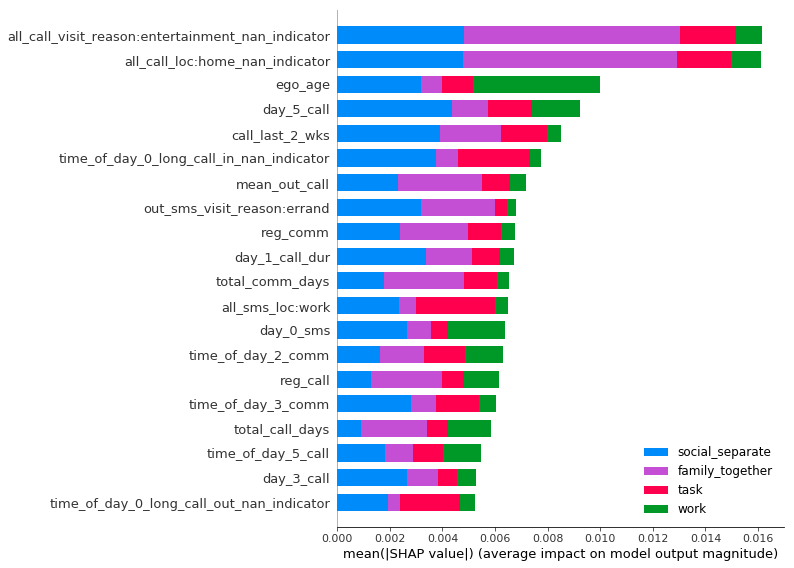

In [141]:
shap.summary_plot(q1_shap_vals, q1_test_features, class_names=contact_types_4clf)

In [13]:
subpop_data_dir = "/home/tliu/relationship-prediction/data/subpop_features/"

q2_train_data = pickle.load(open(subpop_data_dir + "top5_all_q2_train_features.df", "rb"))
q2_test_data = pickle.load(open(subpop_data_dir + "top5_all_q2_test_features.df", "rb"))

q2_train_features = q2_train_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')
q2_test_features = q2_test_data.drop(['pid', 'combined_hash', 'ego_age_q'] + predict_targets, axis=1, errors='ignore')

q2_explainer = shap.KernelExplainer(all_automl_probs['q2_all'], shap.kmeans(q2_train_features, 5), link="logit")
q2_shap_vals = q2_explainer.shap_values(q2_test_features, n_samples=10)

  1%|          | 4/730 [14:38<44:17:23, 219.62s/it]

KeyboardInterrupt: 

In [135]:
shap.summary_plot(q2_shap_vals, q2_test_features)

NameError: name 'q2_shap_vals' is not defined

### Feature analysis

- Cohen's d
- Spearman correlation for age
- t-test for significance
- violin plot (group box plot):
    - gender split
- scatter plot per contact type (loess plot):
    - y is contact frequency, x is age
- try 10-fold CV